In [7]:
#%pylab inline
#%config InlineBackend.figure_format = 'retina' 

In [8]:
#here are some common modules:
import scipy as sp #library of scientific functions
import scipy.io 
import scipy.signal as signal
import numpy as np #library of math functions
import pandas as pd #library of data analysis functions
import matplotlib.pyplot as plt #functions to plot data
import os #This lets python talk to your opperating system to open and save files.
from parabolic import parabolic

In [9]:
filename = 'emodat.mat' #adjut file name here
filename = os.path.join('../FM-BCI', filename) #adjust filepath 
datafile = sp.io.loadmat(filename) #loading filename
#print datafile.keys()
voltageSamples = datafile['data'] 
#print voltageSamples.shape, len(voltageSamples)

In [10]:
variances = []
means = []
medians = []
standardDeviations = []
for i in range(len(voltageSamples)):
    variances.append(np.var(voltageSamples[i,:]))
    means.append(np.mean(voltageSamples[i,:]))
    medians.append(np.median(voltageSamples[i,:]))
    standardDeviations.append(np.std(voltageSamples[i,:]))

In [11]:
for i in range(len(voltageSamples)):
    print 'Channel', i+1
    print '\tmean:', means[i]
    print '\tmedian:', medians[i]
    print '\tstandard deviation:', standardDeviations[i]
    print '\tvariance:', np.var(voltageSamples)

Channel 1
	mean: 53.5051604742
	median: 8.42684103561
	standard deviation: 105.317167517
	variance: 11091.7057739


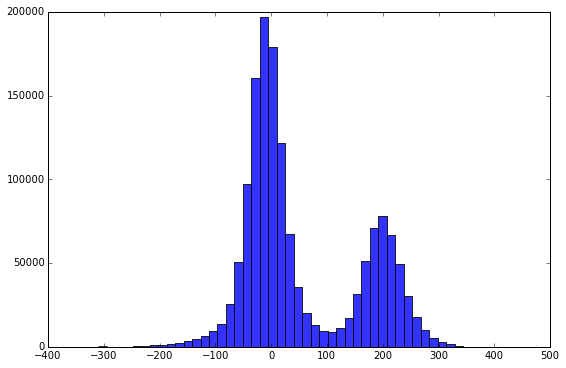

In [12]:
fig1 = plt.figure(1, figsize=(9,6))
numBins = 50
n, bins, patches = plt.hist(voltageSamples[0],numBins,alpha=0.8)


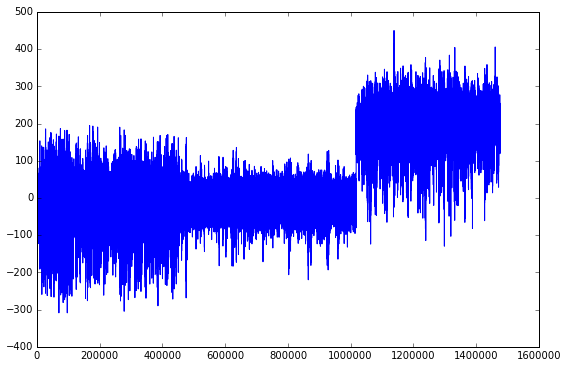

In [7]:
fig2 = plt.figure(2, figsize=(9,6))
plt.plot(voltageSamples[0])

Channel weights: 

         1     1.0


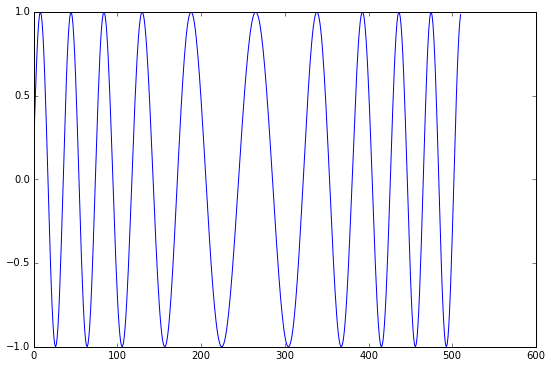

In [6]:
sampleRate = 512 # sample rate assumed during recording
sampleSpacing = 1.0 / sampleRate # time between samples in seconds
dataLengthSecs = 60 # length of whole recording
dataLengthSamples = dataLengthSecs*sampleRate # length of whole recording in samples

t = np.arange(0,dataLengthSecs,sampleSpacing) # time vector spanning length in seconds, with approp. num of samples
#numOfChannel = voltageSamples.shape[0] # determine number of channels from data, i.e. not predefined
numOfChannel = 1
voltageSamples = np.empty([numOfChannel, dataLengthSamples])

# channel weighting
channelWeights = np.linspace(1,1./numOfChannel,numOfChannel) 
#np.random.shuffle(channelWeights)
print 'Channel weights:', '\n'
for channelIndex in range(numOfChannel):
    print "        ", channelIndex+1, "   ", channelWeights[channelIndex]
    
# frequency modulation parameters
alphaCenter = 10.25   # Hz the carrier frequency
alphaModFreq = 1  # Hz the modulating frequency
alphaFreqDev = 4   # Hz of the frequency deviation

# signal to noise parameters
snr = 2             # signal / noise
noiseMean = 0
noiseStdDev = 0.5
alphaMean = 0
alphaStdDev = abs(np.sqrt(snr*(noiseStdDev**2))) # std of sine wave
alphaAmp = np.sqrt(2)*alphaStdDev
h = alphaFreqDev/alphaModFreq         # Modulation index

# Constructs 1/f noise by iteratively adding normal random noise, effectively the CDF of normal dist.
normalNoise = np.random.normal(noiseMean, noiseStdDev, (1,dataLengthSamples))
pinkNoise = np.cumsum(normalNoise)

# Frequency modulated alpha rhythm, a sinusoidal baseband signal
alpha = alphaAmp*np.sin( alphaCenter  * 2.0 * np.pi * t + alphaFreqDev*np.sin(2 * np.pi * alphaModFreq * t) / alphaModFreq)

# assign the weighted alpha rhythm + 1/f noise + additional random noise to each channel in sample
for channelIndex in range(0,numOfChannel):
    voltageSamples[channelIndex,:] = channelWeights[channelIndex]*alpha + pinkNoise + 0.5*np.random.random([1,dataLengthSamples])    
voltageSamples[channelIndex,:] = alpha # change last channel to ground truth alpha

fig3 = plt.figure(3, figsize=(9,6))

channelArray = np.vsplit(voltageSamples,1)
for channelIndex in range(0,numOfChannel):
    plt.plot(voltageSamples[channelIndex,1:sampleRate])
plt.show()


In [46]:
def butter_bandpass(lowcut, highcut, fs, order=4):
        #lowcut is the lower bound of the frequency that we want to isolate
        #hicut is the upper bound of the frequency that we want to isolate
        #fs is the sampling rate of our data
        nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
        low = float(lowcut) / nyq
        high = float(highcut) / nyq
        b, a = sp.signal.butter(order, [low, high], btype='band')
        return b, a

def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sp.signal.filtfilt(b, a, mydata)
    return y

winLengthSecs = 1 # predefine length of window.
winLengthSamples = winLengthSecs*sampleRate # length of window in samples
numOfWindows = int(dataLengthSamples/winLengthSamples) # determine number of windows
channelPeaks = np.empty([numOfChannel, numOfWindows]) # container for peak frequencies for each channel every second
desiredFreqResolution = 0.01 # predefine resolution of spectrum
fftLengthSamples = int(sampleRate/desiredFreqResolution)
nyq = 0.5*sampleRate # maximum possible frequency to measure

bandLow = 9.5                                # lower alpha band 
bandHigh = 10.5                              # higher alpha band
orderFilter = 4  

arrayOfAmps = np.empty([numOfChannel, numOfWindows, len(winAmp)])

for channelIndex in range(0,numOfChannel):
    for winIndex in range(0,numOfWindows):
        channelVoltage = voltageSamples[channelIndex,:]
        channelVoltageFilt = butter_bandpass_filter(channelVoltage, bandLow, bandHigh,sampleRate,orderFilter)
            
        # get next window of data, detrend
        winStart = int(winIndex*winLengthSecs*sampleRate)
        winEnd = int((winIndex+1)*winLengthSecs*sampleRate)
        channelVoltageWin = channelVoltageFilt[winStart:winEnd] - np.mean(channelVoltageFilt[winStart:winEnd])
        
        # window next window of data
        winLengthSamples = len(channelVoltageWin) # determine window length
        #windowed = channelVoltage * signal.blackmanharris(winLengthSamples)
        windowedWin = channelVoltageWin * signal.gaussian(winLengthSamples, std=8,sym=False)
       
        # compute fft
        #TODO Populate new 3D array of shape numOfChannelxnumOfWindowsxlen(winAmp) with amp values
        winAmp = abs(scipy.fftpack.rfft(channelVoltageWin,fftLengthSamples)) # determine amplitude spectrum by taking abs
        freqs = scipy.fftpack.rfftfreq(fftLengthSamples,sampleSpacing) # retrieve frequency axis
        #arrayOfAmps[numOfChannel, numOfWindows, len(winAmp)] = winAmp

        # find peak frequency
        maxAmplitudeIndex = np.argmax(winAmp) # finds simple max amp peak
        true_maxAmplitudeIndex = parabolic(np.log(winAmp), maxAmplitudeIndex-1)[0] # finds parabolic interpolation
        maxFreq = freqs[int(maxAmplitudeIndex)] # retrieves frequency of peak
        true_maxFreq = nyq * true_maxAmplitudeIndex / fftLengthSamples # retrieves frequency of parabolic peak
        print('Channel '+str(channelIndex+1)+ ', Window '+str(winIndex+1)+':     '+str(true_maxFreq)+'  '+str(maxFreq))
        channelPeaks[channelIndex,winIndex] = true_maxFreq # stores peak frequency for every window

Channel 1, Window 1:     9.93499969657  9.94
Channel 1, Window 2:     9.64499989904  9.65
Channel 1, Window 3:     9.92999940699  9.94
Channel 1, Window 4:     9.64999970437  9.66
Channel 1, Window 5:     9.24499952137  9.25
Channel 1, Window 6:     10.0299995216  10.04
Channel 1, Window 7:     10.0899999763  10.1
Channel 1, Window 8:     10.1499997086  10.16
Channel 1, Window 9:     9.73999887204  9.75
Channel 1, Window 10:     9.99499998987  10.0
Channel 1, Window 11:     10.3249997858  10.33
Channel 1, Window 12:     10.3099996969  10.32
Channel 1, Window 13:     9.9099993807  9.92
Channel 1, Window 14:     9.56999973395  9.58
Channel 1, Window 15:     10.0499998172  10.06
Channel 1, Window 16:     9.51499925918  9.52
Channel 1, Window 17:     9.77499961135  9.78
Channel 1, Window 18:     10.1799997165  10.19
Channel 1, Window 19:     9.54499999268  9.55
Channel 1, Window 20:     10.5949999226  10.6
Channel 1, Window 21:     10.2449996612  10.25
Channel 1, Window 22:     10.23999989

In [10]:
print np.median(channelPeaks,1)
print np.mean(channelPeaks,1)

[  9.92749974   9.92749949   9.92749967   9.93249948   9.93999958
   9.92249953   9.92999942  10.15499966]
[  9.97166633   9.95849963   9.98483296   9.96333298   9.95974965
   9.9616663    9.95058299  10.06899974]


In [21]:
chPeakVariances = []
chPeakMeans = []
chPeakMedians = []
chPeakStandardDeviations = []
for i in range(len(channelPeaks)):
    chPeakVariances.append(np.var(channelPeaks[i,:]))
    chPeakMeans.append(np.mean(channelPeaks[i,:]))
    chPeakMedians.append(np.median(channelPeaks[i,:]))
    chPeakStandardDeviations.append(np.std(channelPeaks[i,:]))

In [17]:
for i in range(len(channelPeaks)):
    print 'Channel ' + str(i+1) + ' Peaks'
    print '\tmean:', chPeakMeans[i]
    print '\tmedian:', chPeakMedians[i]
    print '\tstandard deviation:', chPeakStandardDeviations[i]
    print '\tvariance:', chPeakVariances[i]

Channel 1 Peaks
	mean: 9.97166633491
	median: 9.92749973847
	standard deviation: 0.349191491068
	variance: 0.121934697434
Channel 2 Peaks
	mean: 9.95849963242
	median: 9.92749948632
	standard deviation: 0.352118964048
	variance: 0.123987764842
Channel 3 Peaks
	mean: 9.98483296343
	median: 9.92749966768
	standard deviation: 0.357027010275
	variance: 0.127468286066
Channel 4 Peaks
	mean: 9.96333297527
	median: 9.93249948466
	standard deviation: 0.338651257267
	variance: 0.114684674048
Channel 5 Peaks
	mean: 9.95974964573
	median: 9.93999958312
	standard deviation: 0.344014748016
	variance: 0.118346146853
Channel 6 Peaks
	mean: 9.96166629915
	median: 9.9224995345
	standard deviation: 0.318611148859
	variance: 0.101513064177
Channel 7 Peaks
	mean: 9.95058299177
	median: 9.92999941947
	standard deviation: 0.319263616339
	variance: 0.101929256718
Channel 8 Peaks
	mean: 10.0689997449
	median: 10.1549996595
	standard deviation: 0.403058903172
	variance: 0.162456479426


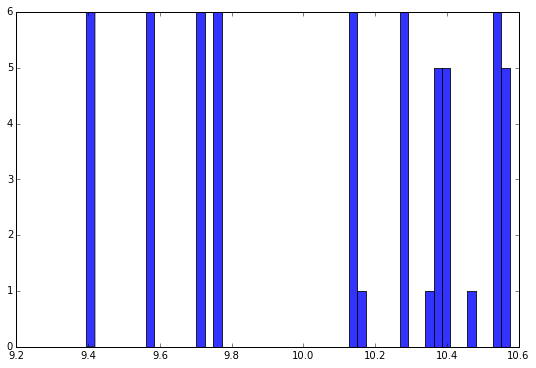

In [18]:
# Do this for all channels, one figure using subplot, each channel with its own subplot
fig4 = plt.figure(4, figsize=(9,6))
numBins = 50
n, bins, patches = plt.hist(channelPeaks[7],numBins,alpha=0.8)

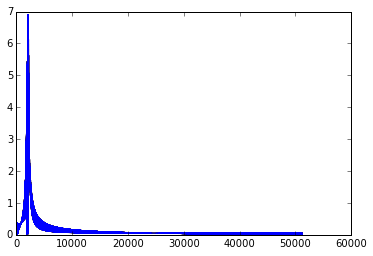

In [20]:
# plot amp for each channel
#for each channel
    #for each window
        #plot 3d figure with time on horizontal, freqs on vertical, and winAmp as the fluctuating value
for i in range(numOfChannel):
    plt.plot(winAmp)